In [1]:
import numpy as np
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# Data pre processing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error


In [2]:
# Using either cpu or gpu{cuda}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
device

device(type='cpu')

In [3]:
# Data acquisition
ticker ="AAPL"
df = yf.download(ticker,"2020-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
df.to_csv("AAPL_stock_data_2020_01_01.csv")

### We are going to observe the closing price only
#### -- This is to be realistic for the last price possible

<Axes: xlabel='Date'>

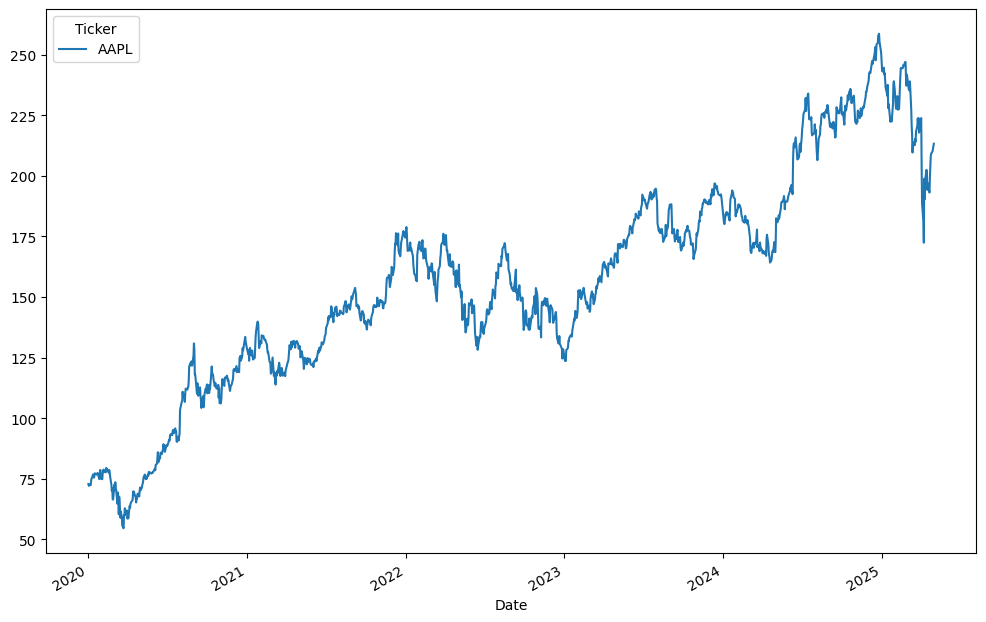

In [5]:
    df.Close.plot(figsize= (12,8))

### We are going to take the portion of data to train the model (80%) and (20%) evaluating the model

In [6]:
# Introducing scaler for modellin the data in the normal distribution with mean= 0 and sd=1 
# so as to feed them in the nearal network
scaler  = StandardScaler()
#You can transform the test and trainging separately but to keep things simple
df["Close"] = scaler.fit_transform(df["Close"])  

In [7]:
df.Close.head()

Ticker,AAPL
Date,
2020-01-02,-1.888201
2020-01-03,-1.904124
2020-01-06,-1.891200
2020-01-07,-1.898889
2020-01-08,-1.872714


In [8]:
sequence_length=30 #Number of days to be considered before or necessary for prediction
data = []
for i in range(len(df)-sequence_length):
    data.append(df.Close[i:i+sequence_length])

data = np.array(data) # Converting them to be numpy array


In [9]:
data # This data has multidimensional characteristics ,at least three dimension for each separate cluster

array([[[-1.88820109],
        [-1.90412401],
        [-1.89120032],
        ...,
        [-1.77903617],
        [-1.73754769],
        [-1.7502839 ]],

       [[-1.90412401],
        [-1.89120032],
        [-1.8988894 ],
        ...,
        [-1.73754769],
        [-1.7502839 ],
        [-1.74984638]],

       [[-1.89120032],
        [-1.8988894 ],
        [-1.87271397],
        ...,
        [-1.7502839 ],
        [-1.74984638],
        [-1.78237015]],

       ...,

       [[ 1.29410917],
        [ 1.2646025 ],
        [ 1.32203933],
        ...,
        [ 1.16729771],
        [ 1.18779483],
        [ 1.20716567]],

       [[ 1.2646025 ],
        [ 1.32203933],
        [ 1.29636173],
        ...,
        [ 1.18779483],
        [ 1.20716567],
        [ 1.23126675]],

       [[ 1.32203933],
        [ 1.29636173],
        [ 1.39028768],
        ...,
        [ 1.20716567],
        [ 1.23126675],
        [ 1.26032284]]], shape=(1310, 30, 1))

In [10]:
# Splitting the dataset into training and testing sets
training_size = int(0.8*len(data))
X_train = torch.from_numpy(data[:training_size,:-1,:]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:training_size,-1,:]).type(torch.Tensor).to(device)

# Testing portions

X_test = torch.from_numpy(data[training_size:,:-1,:]).type(torch.Tensor).to(device) # We start from the last portion of the data-point and start predicting each day
y_test = torch.from_numpy(data[training_size:,-1,:]).type(torch.Tensor).to(device)

### Creating a class for the model training

In [11]:
class PredictionModel(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(PredictionModel,self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True,dropout=0.2)
        self.fc = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        # Ensure input is 3D: (batch, seq_len, input_size)
        if x.dim() == 2:
            x = x.unsqueeze(0)  # Add batch dimension
    
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim,device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim,device=device)
    
        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach() ) )  # LSTM output
        out = self.fc(out[:, -1, :])     # Take output from lasta time step
        return out




In [12]:
# Intializing the model
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize model AFTER defining optimizer


# Training loop
num_epochs = 200
for i in range(num_epochs):
    model.train()  # Set model to training mode

    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 25 == 0:
        print(f"Epoch {i}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.7313
Epoch 25: Loss = 0.0151
Epoch 50: Loss = 0.0099
Epoch 75: Loss = 0.0084
Epoch 100: Loss = 0.0075
Epoch 125: Loss = 0.0072
Epoch 150: Loss = 0.0064
Epoch 175: Loss = 0.0065


In [13]:
y_train_pred.shape

torch.Size([1048, 1])

In [14]:
model.eval()
y_test_pred = model(X_test)


# y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
# y_train = scaler.inverse_transform(Y_train.detach().cpu().numpy())
# y_test_predict = scaler.inverse_transform(y_test_predict.detach().cpu().numpy())
# y_test = scaler.inverse_transform(Y_test.detach().cpu().numpy())

if isinstance(y_train_pred, torch.Tensor):
    y_train_pred = y_train_pred.detach().cpu().numpy()

y_train_pred = scaler.inverse_transform(y_train_pred)
if isinstance(Y_train, torch.Tensor):
    y_train = scaler.inverse_transform(Y_train.detach().cpu().numpy())
else:
    y_train = scaler.inverse_transform(Y_train)

if isinstance(y_test_pred, torch.Tensor):
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
else:
    y_test_pred = scaler.inverse_transform(y_test_pred)
if isinstance(y_test, torch.Tensor):
    y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())



In [15]:
train_rmse = root_mean_squared_error(y_train[:,0],y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0],y_test_pred[:,0])

print(f"Trainining Rmse: {train_rmse} \n Test Rmse {test_rmse}")

Trainining Rmse: 3.3894944190979004 
 Test Rmse 14.711731910705566


## Plots for visualization on our prediction

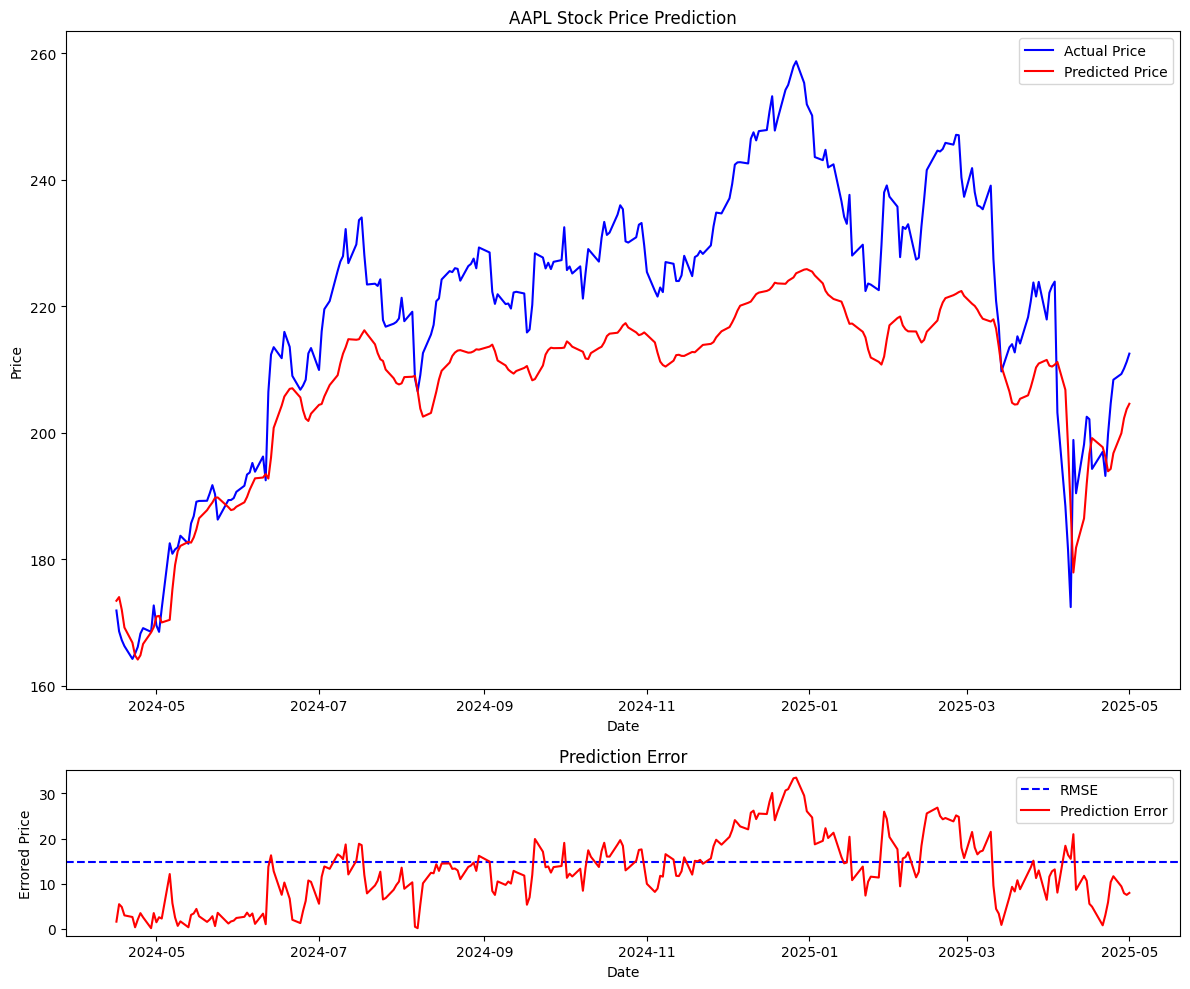

In [16]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1)

# Upper plot (Actual vs Predicted)
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color="blue", label="Actual Price")
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color="red", label="Predicted Price")
ax1.legend()
ax1.set_title(f"{ticker} Stock Price Prediction")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")

# Lower plot (Prediction Error)
ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color="blue", linestyle="--", label="RMSE")
ax2.plot(df.iloc[-len(y_test):].index, abs(y_test - y_test_pred), color="red", label="Prediction Error")
ax2.legend()
ax2.set_title("Prediction Error")
ax2.set_xlabel("Date")
ax2.set_ylabel("Errored Price")

plt.tight_layout()
plt.show()

/home/jelius/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch   0 | Train Loss: 0.2703 | Val Loss: 1.3268
Epoch   1 | Train Loss: 0.2594 | Val Loss: 1.2664
Epoch   2 | Train Loss: 0.2301 | Val Loss: 1.1949
Epoch   3 | Train Loss: 0.2100 | Val Loss: 1.1117
Epoch   4 | Train Loss: 0.1647 | Val Loss: 1.0073
Epoch   5 | Train Loss: 0.1372 | Val Loss: 0.8845
Epoch   6 | Train Loss: 0.0860 | Val Loss: 0.7517
Epoch   7 | Train Loss: 0.0630 | Val Loss: 0.6216
Epoch   8 | Train Loss: 0.0463 | Val Loss: 0.4881
Epoch   9 | Train Loss: 0.0367 | Val Loss: 0.4391
Epoch  10 | Train Loss: 0.0323 | Val Loss: 0.3915
Epoch  11 | Train Loss: 0.0355 | Val Loss: 0.3653
Epoch  12 | Train Loss: 0.0294 | Val Loss: 0.3201
Epoch  13 | Train Loss: 0.0267 | Val Loss: 0.2971
Epoch  14 | Train Loss: 0.0242 | Val Loss: 0.2587
Epoch  15 | Train Loss: 0.0243 | Val Loss: 0.2287
Epoch  16 | Train Loss: 0.0207 | Val Loss: 0.2295
Epoch  17 | Train Loss: 0.0200 | Val Loss: 0.2114
Epoch  18 | Train Loss: 0.0194 | Val Loss: 0.2083
Epoch  19 | Train Loss: 0.0202 | Val Loss: 0.2012


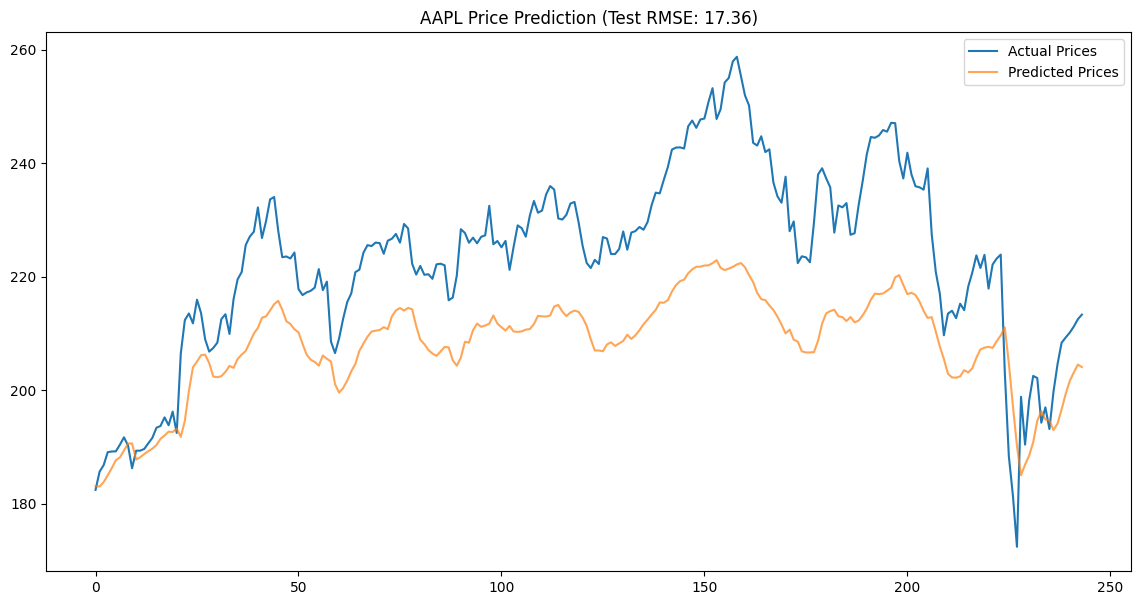

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Advanced Data Pipeline -------------------------------------------
def create_sequences(data, targets, window_size):
    X, Y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        Y.append(targets[i+window_size])
    return np.array(X), np.array(Y)

# Load and preprocess data
df = pd.read_csv("AAPL_stock_data_2020_01_01.csv", header=0, skiprows=[1,2])
df = df.rename(columns={'Price': 'Date'}).dropna(how='all')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Add technical indicators
df['SMA_20'] = df['Close'].rolling(20).mean()
df['RSI'] = 100 - (100 / (1 + (df['Close'].diff(1).clip(lower=0).rolling(14).mean() / 
                       df['Close'].diff(1).clip(upper=0).abs().rolling(14).mean())))
df = df.dropna()

# Feature selection
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'RSI']
target = 'Close'

# 2. Proper Data Scaling & Splitting ----------------------------------
# Split BEFORE scaling to prevent leakage
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Scale data using RobustScaler (less sensitive to outliers)
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X_train = scaler_x.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[[target]])

X_test = scaler_x.transform(test_df[features])
y_test = scaler_y.transform(test_df[[target]])

# Create sequences with optimal window size
window_size = 21  # 3 trading weeks
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# 3. Regularized Model Architecture ----------------------------------
class FinancialLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, 1)
        
        # Weight initialization
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
                
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        return self.fc(out)

model = FinancialLSTM(input_size=len(features)).to(device)

# 4. Enhanced Training Protocol ---------------------------------------
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                        steps_per_epoch=len(X_train_seq)//32,
                                        epochs=100)
criterion = nn.HuberLoss()  # More robust to outliers

# Convert to tensors
train_data = torch.utils.data.TensorDataset(
    torch.tensor(X_train_seq, dtype=torch.float32),
    torch.tensor(y_train_seq, dtype=torch.float32)
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 10
trials = 0

for epoch in range(100):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(torch.tensor(X_test_seq, dtype=torch.float32).to(device))
        val_loss = criterion(val_preds, torch.tensor(y_test_seq).to(device))
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trials = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    print(f'Epoch {epoch:3d} | Train Loss: {epoch_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}')

# 5. Strict Evaluation -----------------------------------------------
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    test_preds = model(torch.tensor(X_test_seq, dtype=torch.float32).to(device)).cpu().numpy()

# Inverse scaling
test_preds = scaler_y.inverse_transform(test_preds)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Calculate metrics with proper dtype specification
train_rmse = np.sqrt(mean_squared_error(
    scaler_y.inverse_transform(y_train_seq),
    scaler_y.inverse_transform(
        model(torch.tensor(X_train_seq, dtype=torch.float32).to(device))
        .cpu().detach().numpy()
    )
))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_preds))

print(f'\nTrain RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Generalization Gap: {test_rmse-train_rmse:.2f}')

# Visual inspection
plt.figure(figsize=(14,7))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(test_preds, label='Predicted Prices', alpha=0.7)
plt.title(f'AAPL Price Prediction (Test RMSE: {test_rmse:.2f})')
plt.legend()
plt.show()

In [24]:
df.

Index(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], dtype='object')

In [21]:
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,72.716064453125,72.77659055848162,71.4668047519516,71.72101143907315,135480400
3,2020-01-03,72.00914001464844,72.77176771569704,71.78398460177141,71.94135104985396,146322800
4,2020-01-06,72.5829086303711,72.62164622763687,70.87607527260708,71.12786596061405,118387200
...,...,...,...,...,...,...
1337,2025-04-25,209.27999877929688,209.75,206.1999969482422,206.3699951171875,38222300
1338,2025-04-28,210.13999938964844,211.5,207.4600067138672,210.0,38743100
1339,2025-04-29,211.2100067138672,212.24000549316406,208.3699951171875,208.69000244140625,36827600
1340,2025-04-30,212.5,213.5800018310547,206.6699981689453,209.3000030517578,52286500


Using device: cpu


/tmp/ipykernel_508442/2701625512.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Handle date parsing errors gracefully
/tmp/ipykernel_508442/2701625512.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/home/jelius/venv/lib/python3.12/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/home/jelius/venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weigh

Epoch 0: Train Loss 0.4852, Val Loss 0.4473
Epoch 10: Train Loss 0.0408, Val Loss 0.0500
Epoch 20: Train Loss 0.0394, Val Loss 0.0391
Epoch 30: Train Loss 0.0359, Val Loss 0.0478
Epoch 40: Train Loss 0.0335, Val Loss 0.0308
Epoch 50: Train Loss 0.0339, Val Loss 0.0438
Epoch 60: Train Loss 0.0293, Val Loss 0.0378
Early stopping at epoch 60
Day 1 Metrics: {'MSE': np.float64(77.43888218414664), 'RMSE': np.float64(8.79993648750641), 'MAE': np.float64(7.59386453597381), 'MAPE': np.float64(3.332067174685977)}
Day 2 Metrics: {'MSE': np.float64(85.69112091393495), 'RMSE': np.float64(9.256949870985311), 'MAE': np.float64(7.872063050703113), 'MAPE': np.float64(3.4606303244094314)}
Day 3 Metrics: {'MSE': np.float64(83.17120724857347), 'RMSE': np.float64(9.119824957123544), 'MAE': np.float64(7.534080775759499), 'MAPE': np.float64(3.328209665269383)}
Visualizations saved to 'visualizations' directory.


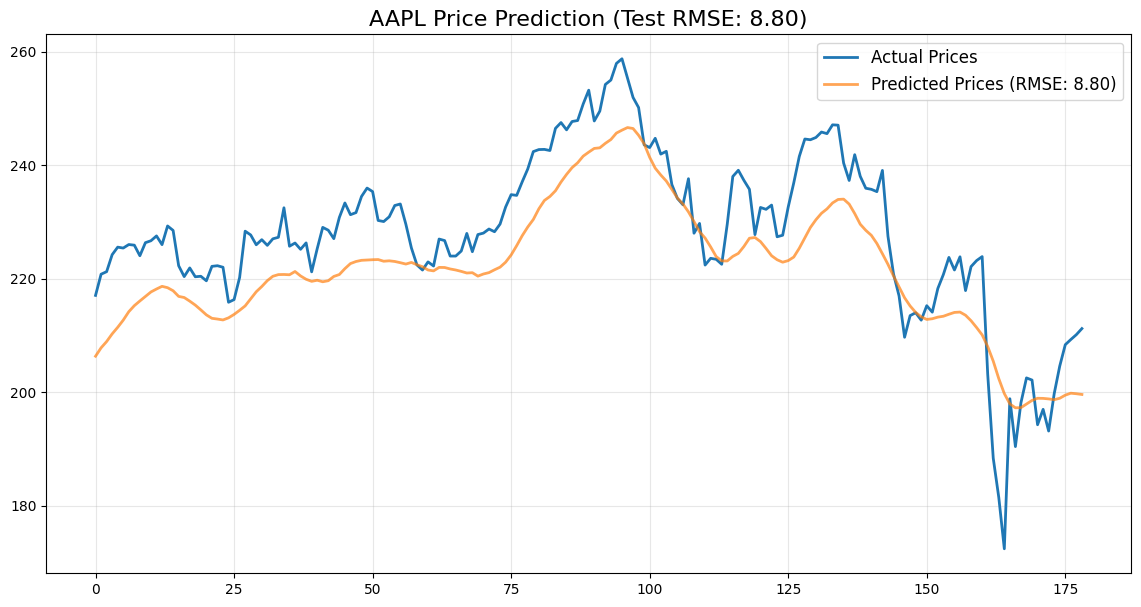

Analysis complete. Results saved.

=== Running Enhanced Risk-Managed Investment Analysis ===
Using prediction standard deviation for confidence-based sizing
Successfully calculated prediction std (shape: (179,))
Using prediction std with shape: (179,)

=== Risk-Managed Investment Performance (Starting with $100) ===
Final Portfolio Value: $106.99
Total Return: 6.99%
Annualized Return: 10.03%
Maximum Drawdown: 3.90%
Drawdown Reduction: 13.64%
Performance ratio vs original: 0.59x


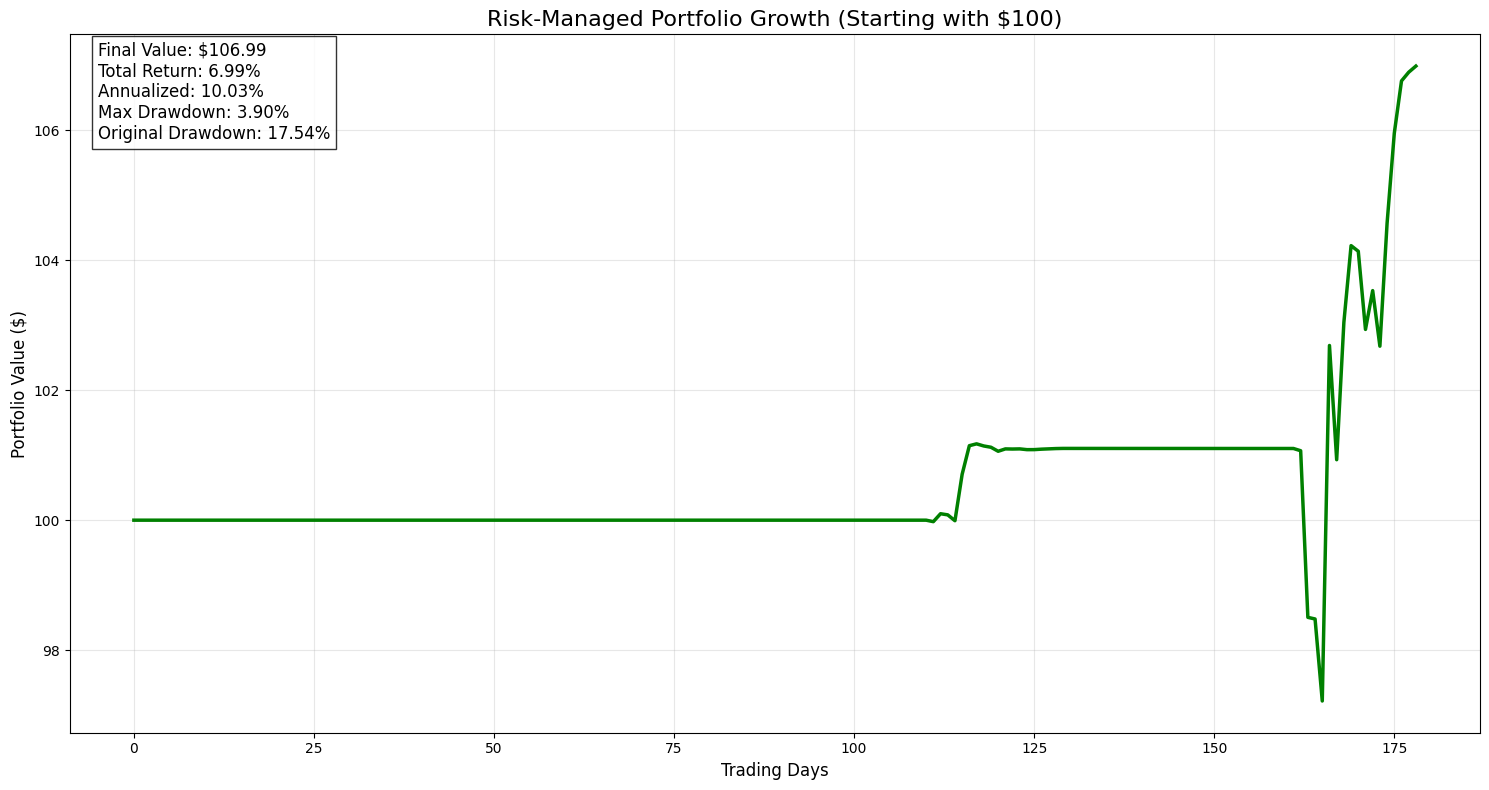


=== Risk Management Analysis Complete ===
Enhanced trading strategy results and comparisons saved to visualizations directory
Drawdown reduced from 17.54% to 3.90%

=== Model Comparison ===
Deep TCN Model RMSE: 8.80
Random Forest RMSE: 42.22
Linear Regression RMSE: 4.90
Improvement over Linear Regression: -79.59%
Improvement over Random Forest: 79.16%

=== SUMMARY REPORT ===
Our model predicts that starting with $100 would result in $111.88
This represents a 11.88% return over the test period
The model outperformed simple baselines by up to 79.16%
Maximum drawdown during trading: 17.54%
Trading summary: 15 buys, 15 sells

Visualization and detailed logs saved to the 'visualizations' directory


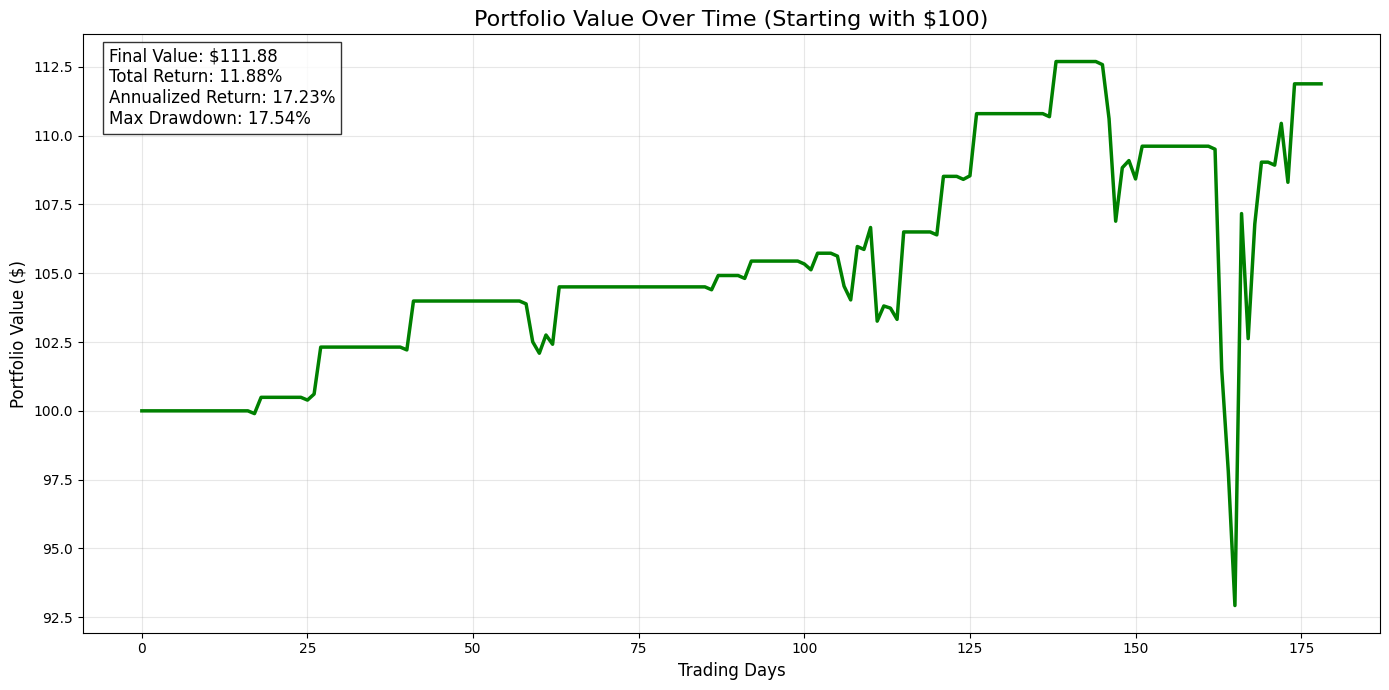

In [2]:
pip freeze 


anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.4
bleach==6.2.0
certifi==2025.4.26
cffi==1.17.1
charset-normalizer==3.4.1
cloudpickle==3.1.1
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
debugpy==1.8.14
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.0
Farama-Notifications==0.0.4
fastjsonschema==2.21.1
filelock==3.18.0
fonttools==4.57.0
fqdn==1.5.1
frozendict==2.4.6
fsspec==2025.3.2
gym==0.26.2
gym-notices==0.0.8
gymnasium==1.1.1
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.10
ipykernel==6.29.5
ipython==9.2.0
ipython_pygments_lexers==1.1.1
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
json5==0.12.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2025.4.1
jupyter-events==0.12.0
jupyter-lsp==2.2.5
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyter_server==2.15.0
jupyter_server_terminals==0.5.3
jupyterlab==4.4.1
jupyterlab_pygments==0.3.0
jupyt

In [3]:
touch README.md


SyntaxError: invalid syntax (145152113.py, line 1)